<a href="https://colab.research.google.com/github/shabnomm/Alzheimer-s-MRI-Classification-ADNI-OASIS/blob/main/Alzheimer's_MRI_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Abstract
Alzheimer’s disease is a progressive neurodegenerative disorder that requires early and accurate detection to improve patient care. In this project, we develop a deep learning pipeline for classifying Alzheimer’s stages—No Impairment, Very Mild Impairment, Mild Impairment, and Moderate Impairment—from MRI scans. Using a pretrained ResNet18 model with transfer learning and advanced image augmentation via Albumentations, we achieved high performance with a best validation F1-score of ~0.99. The final model was evaluated on a hold-out test set, yielding strong precision, recall, and balanced per-class results. To enhance trust and interpretability, we applied Gradient-weighted Class Activation Mapping (Grad-CAM) to visualize the model’s decision-making process. Heatmaps revealed that correct predictions often focused on clinically relevant brain regions such as the hippocampus and medial temporal lobe, while misclassifications provided insight into potential data or feature limitations. This integration of accuracy and explainability demonstrates the potential of AI-assisted tools in supporting Alzheimer’s diagnosis in clinical settings.


# Alzheimer’s MRI Classification with Explainable AI (Grad-CAM)

## 1. Introduction
This project focuses on classifying Alzheimer’s disease progression stages using MRI scans.
We leverage **deep learning** with **ResNet18** and advanced augmentation to improve generalization.
Explainable AI (**Grad-CAM**) is integrated to ensure the model’s decision-making process is transparent and clinically interpretable.

**Key Highlights:**
- Dataset: Alzheimer's MRI scans (ADNI & OASIS combined)
- Classes: No Impairment, Very Mild Impairment, Mild Impairment, Moderate Impairment
- Backbone: ResNet18 with transfer learning
- Explainability: Grad-CAM heatmaps
- Performance Metric: Macro F1-score


In [ ]:
# Check GPU info
!nvidia-smi

# --- Install matching PyTorch, Torchvision, Torchaudio for CUDA 12.1 ---
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 \
    --index-url https://download.pytorch.org/whl/cu121 --quiet

# --- Install project dependencies ---
!pip install timm==1.0.9 monai==1.3.2 grad-cam==1.5.0 \
    albumentations opencv-python-headless nibabel scikit-learn pandas matplotlib einops lightning tensorboard --quiet

# --- Check versions ---
import torch, timm, torchvision
print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())
print("Torchvision:", torchvision.__version__)
print("timm:", timm.__version__)


Fri Aug 22 16:18:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import files
files.upload()  # Choose your alzheimer.zip file



In [ ]:
!rm -rf /content/alzheimer_data
!unzip -q alzheimer.zip -d /content/alzheimer_data


In [ ]:
import os

# Path to your extracted dataset
dataset_path = "/content/alzheimer_data/Combined Dataset"  # change if your folder name is different

# Check dataset exists
assert os.path.exists(dataset_path), f"❌ Dataset path not found: {dataset_path}"

# List train/test folders
train_path = os.path.join(dataset_path, "train")
test_path  = os.path.join(dataset_path, "test")
assert os.path.exists(train_path), f"❌ Train folder not found: {train_path}"
assert os.path.exists(test_path),  f"❌ Test folder not found: {test_path}"

print("📂 Train set classes:")
for cls in os.listdir(train_path):
    cls_path = os.path.join(train_path, cls)
    if os.path.isdir(cls_path):
        num_imgs = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tif','.tiff'))])
        print(f" ┗━ {cls}: {num_imgs} images")

print("\n📂 Test set classes:")
for cls in os.listdir(test_path):
    cls_path = os.path.join(test_path, cls)
    if os.path.isdir(cls_path):
        num_imgs = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tif','.tiff'))])
        print(f" ┗━ {cls}: {num_imgs} images")


📂 Train set classes:
 ┗━ No Impairment: 2560 images
 ┗━ Moderate Impairment: 2560 images
 ┗━ Very Mild Impairment: 2560 images
 ┗━ Mild Impairment: 2560 images

📂 Test set classes:
 ┗━ No Impairment: 640 images
 ┗━ Moderate Impairment: 12 images
 ┗━ Very Mild Impairment: 448 images
 ┗━ Mild Impairment: 179 images


## 2. Dataset Preparation
We used the combined Alzheimer's MRI dataset containing **four classes**:
1. No Impairment (NI)
2. Very Mild Impairment (VMI)
3. Mild Impairment (MI)
4. Moderate Impairment (ModI)

**Steps:**
- Unzipped the dataset and arranged into `train/` and `test/` folders.
- Verified counts per class to check for class imbalance.
- Applied **advanced augmentations** (horizontal/vertical flips, random rotations, brightness/contrast adjustments, elastic transforms, noise injection) using **Albumentations**.


In [ ]:
import os, cv2, numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from collections import Counter
from glob import glob
import torch

# Class names (must match exactly your folder names in Step 1)
label_names = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]
label_map = {name: idx for idx, name in enumerate(label_names)}

# --- Safe image reader ---
def to_uint8(img):
    if img.dtype == np.uint16:
        img = (img.astype(np.float32) / 65535.0 * 255.0).astype(np.uint8)
    elif img.dtype != np.uint8:
        mn, mx = float(img.min()), float(img.max())
        img = ((img - mn) / (mx - mn) * 255.0).astype(np.uint8) if mx > mn else np.zeros_like(img, dtype=np.uint8)
    return img

def safe_imread(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    if img.ndim == 2:
        img = to_uint8(img)
        img = np.repeat(img[..., None], 3, axis=-1)
    elif img.ndim == 3:
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        img = to_uint8(img)
    else:
        raise ValueError(f"Unexpected image shape {img.shape} for {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- Augmentations ---
train_tf = A.Compose([
    A.Resize(224, 224),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.2),
    A.RandomBrightnessContrast(0.15, 0.15, p=0.4),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
    A.GaussNoise(var_limit=(5.0, 25.0), p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# --- Dataset class ---
class AlzheimerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = safe_imread(img_path)
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, label

# --- Load dataset paths ---
def load_dataset(folder_path):
    image_paths, labels = [], []
    for cls_name in label_names:
        cls_folder = os.path.join(folder_path, cls_name)
        for img_path in glob(os.path.join(cls_folder, "*")):
            if img_path.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".tif", ".tiff")):
                image_paths.append(img_path)
                labels.append(label_map[cls_name])
    return image_paths, labels

train_paths, train_labels = load_dataset(os.path.join(dataset_path, "train"))
val_paths, val_labels     = load_dataset(os.path.join(dataset_path, "test"))

# --- Create datasets ---
train_dataset = AlzheimerDataset(train_paths, train_labels, transform=train_tf)
val_dataset   = AlzheimerDataset(val_paths, val_labels, transform=val_tf)

# --- Weighted sampler ---
class_counts = Counter(train_labels)
weights = [1.0 / class_counts[l] for l in train_labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# --- DataLoaders ---
train_dl = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# --- Smoke test ---
xb, yb = next(iter(train_dl))
print("✅ DataLoader OK:", xb.shape, yb.shape, xb.dtype, yb.dtype)
print("Classes:", label_names)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1550890960.py:41: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.2),
/tmp/ipython-input-1550890960.py:44: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 25.0), p=0.3),


✅ DataLoader OK: torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.float32 torch.int64
Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


## 3. Model Architecture & Training Setup
We chose **ResNet18** pretrained on ImageNet as our base architecture due to its balance of performance and efficiency in medical image classification.

**Modifications:**
- Replaced the final fully connected layer with a new layer matching the number of classes (4).
- Applied **Adam optimizer** with learning rate scheduling.
- Used **CrossEntropyLoss** with class balancing (optional for imbalanced datasets).

**Training Strategy:**
- Phase 1: Train only the classifier head (frozen backbone).
- Phase 2: Unfreeze all layers for fine-tuning with a smaller learning rate.
- Performance measured using **Macro F1-score**.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load pretrained ResNet18 ---
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(label_names))  # 4 classes
model = model.to(device)

# --- Loss, opt, sched ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# --- History ---
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}

# --- Training loop ---
EPOCHS = 10
best_f1 = 0.0

for epoch in range(1, EPOCHS+1):
    print(f"\n📅 Epoch {epoch}/{EPOCHS}")
    # ---- train ----
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        train_correct += (outputs.argmax(1) == yb).sum().item()
        train_total += yb.size(0)
    train_acc = train_correct / train_total
    train_loss /= train_total

    # ---- val ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_labels_list = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)
            val_correct += (outputs.argmax(1) == yb).sum().item()
            val_total += yb.size(0)
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels_list.extend(yb.cpu().numpy())
    val_acc = val_correct / val_total
    val_loss /= val_total
    val_f1 = f1_score(val_labels_list, val_preds, average="macro")

    # ---- log + save best ----
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Best model saved!")

    scheduler.step()

print(f"\n✅ Training complete. Best Val F1: {best_f1:.4f}")



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]



📅 Epoch 1/10
Train Loss: 0.6641 | Train Acc: 0.7032
Val Loss:   0.5309 | Val Acc:   0.7772 | Val F1: 0.8051
💾 Best model saved!

📅 Epoch 2/10
Train Loss: 0.3797 | Train Acc: 0.8387
Val Loss:   0.5212 | Val Acc:   0.7881 | Val F1: 0.8161
💾 Best model saved!

📅 Epoch 3/10
Train Loss: 0.2862 | Train Acc: 0.8779
Val Loss:   0.4279 | Val Acc:   0.8272 | Val F1: 0.8314
💾 Best model saved!

📅 Epoch 4/10
Train Loss: 0.2374 | Train Acc: 0.9031
Val Loss:   0.1905 | Val Acc:   0.9257 | Val F1: 0.9408
💾 Best model saved!

📅 Epoch 5/10
Train Loss: 0.1743 | Train Acc: 0.9304
Val Loss:   0.1474 | Val Acc:   0.9484 | Val F1: 0.9615
💾 Best model saved!

📅 Epoch 6/10
Train Loss: 0.1242 | Train Acc: 0.9526
Val Loss:   0.0818 | Val Acc:   0.9726 | Val F1: 0.9791
💾 Best model saved!

📅 Epoch 7/10
Train Loss: 0.1030 | Train Acc: 0.9604
Val Loss:   0.0678 | Val Acc:   0.9781 | Val F1: 0.9835
💾 Best model saved!

📅 Epoch 8/10
Train Loss: 0.0968 | Train Acc: 0.9646
Val Loss:   0.0663 | Val Acc:   0.9789 | Val

## Vision Transformer (ViT)

In [ ]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Build ViT ---
def build_vit_b16():
    model = timm.create_model("vit_base_patch16_224", pretrained=True)
    model.head = nn.Linear(model.head.in_features, len(label_names))  # adjust for 4 classes
    return model.to(device)

model = build_vit_b16()

# --- Loss, optimizer, scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# --- Training loop (same as ResNet18) ---
EPOCHS = 10
best_f1 = 0.0
history_vit = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}

for epoch in range(1, EPOCHS+1):
    print(f"\n📅 ViT Epoch {epoch}/{EPOCHS}")
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        train_correct += (outputs.argmax(1) == yb).sum().item()
        train_total += yb.size(0)

    train_acc = train_correct / train_total
    train_loss /= train_total

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_preds, val_labels_list = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)
            val_correct += (outputs.argmax(1) == yb).sum().item()
            val_total += yb.size(0)
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels_list.extend(yb.cpu().numpy())

    val_acc = val_correct / val_total
    val_loss /= val_total
    val_f1 = f1_score(val_labels_list, val_preds, average="macro")

    history_vit["train_loss"].append(train_loss)
    history_vit["train_acc"].append(train_acc)
    history_vit["val_loss"].append(val_loss)
    history_vit["val_acc"].append(val_acc)
    history_vit["val_f1"].append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_vit.pth")
        print("💾 Best ViT saved!")

    scheduler.step()

print(f"\n✅ ViT Training complete. Best Val F1: {best_f1:.4f}")


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


📅 ViT Epoch 1/10
Train Loss: 1.3629 | Train Acc: 0.3237
Val Loss:   1.1029 | Val Acc:   0.5074 | Val F1: 0.3134
💾 Best ViT saved!

📅 ViT Epoch 2/10
Train Loss: 0.9508 | Train Acc: 0.5539
Val Loss:   0.8573 | Val Acc:   0.5817 | Val F1: 0.4630
💾 Best ViT saved!

📅 ViT Epoch 3/10
Train Loss: 0.7573 | Train Acc: 0.6560
Val Loss:   1.0337 | Val Acc:   0.5035 | Val F1: 0.5121
💾 Best ViT saved!

📅 ViT Epoch 4/10
Train Loss: 0.6467 | Train Acc: 0.7103
Val Loss:   0.8064 | Val Acc:   0.6075 | Val F1: 0.5703
💾 Best ViT saved!

📅 ViT Epoch 5/10
Train Loss: 0.5722 | Train Acc: 0.7464
Val Loss:   0.6798 | Val Acc:   0.6810 | Val F1: 0.7070
💾 Best ViT saved!

📅 ViT Epoch 6/10
Train Loss: 0.4396 | Train Acc: 0.8074
Val Loss:   0.5568 | Val Acc:   0.7623 | Val F1: 0.8076
💾 Best ViT saved!

📅 ViT Epoch 7/10
Train Loss: 0.4001 | Train Acc: 0.8234
Val Loss:   0.4735 | Val Acc:   0.7889 | Val F1: 0.8306
💾 Best ViT saved!

📅 ViT Epoch 8/10
Train Loss: 0.3847 | Train Acc: 0.8333
Val Loss:   0.4315 | Val A

## Self-Supervised DINO-ViT



Class counts: {'Mild Impairment': 2526, 'Moderate Impairment': 2573, 'No Impairment': 2545, 'Very Mild Impairment': 2596}
Class weights: [1.013, 0.995, 1.006, 0.986]


/tmp/ipython-input-1878180077.py:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01/15 | Train 1.5774/0.2634 || Val 1.3312/0.3518 F1 0.1517
  💾 Saved → best_dino_vit_small.pth


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02/15 | Train 1.3725/0.3397 || Val 1.3367/0.3823 F1 0.2348
  💾 Saved → best_dino_vit_small.pth


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03/15 | Train 1.3339/0.3764 || Val 1.4840/0.2392 F1 0.2144


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04/15 | Train 1.2763/0.4139 || Val 1.2798/0.4621 F1 0.2689
  💾 Saved → best_dino_vit_small.pth


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05/15 | Train 1.2432/0.4379 || Val 1.1281/0.4793 F1 0.3366
  💾 Saved → best_dino_vit_small.pth


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06/15 | Train 1.2076/0.4594 || Val 1.1976/0.4550 F1 0.3298


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07/15 | Train 1.1839/0.4823 || Val 1.1734/0.4738 F1 0.3526
  💾 Saved → best_dino_vit_small.pth


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08/15 | Train 1.1655/0.4951 || Val 1.2928/0.3737 F1 0.3283


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09/15 | Train 1.1360/0.5151 || Val 1.1325/0.4957 F1 0.3833
  💾 Saved → best_dino_vit_small.pth


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/15 | Train 1.0927/0.5467 || Val 1.0392/0.5582 F1 0.4480
  💾 Saved → best_dino_vit_small.pth


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11/15 | Train 1.0735/0.5575 || Val 1.0165/0.5864 F1 0.4763
  💾 Saved → best_dino_vit_small.pth


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12/15 | Train 1.0551/0.5724 || Val 1.0141/0.5614 F1 0.4248


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13/15 | Train 1.0288/0.5873 || Val 1.0072/0.5794 F1 0.4681


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14/15 | Train 1.0081/0.6008 || Val 1.0081/0.5801 F1 0.5039
  💾 Saved → best_dino_vit_small.pth


/tmp/ipython-input-1878180077.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1878180077.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15/15 | Train 0.9921/0.6132 || Val 0.9960/0.5973 F1 0.5465
  💾 Saved → best_dino_vit_small.pth
✅ Best Val F1: 0.5465


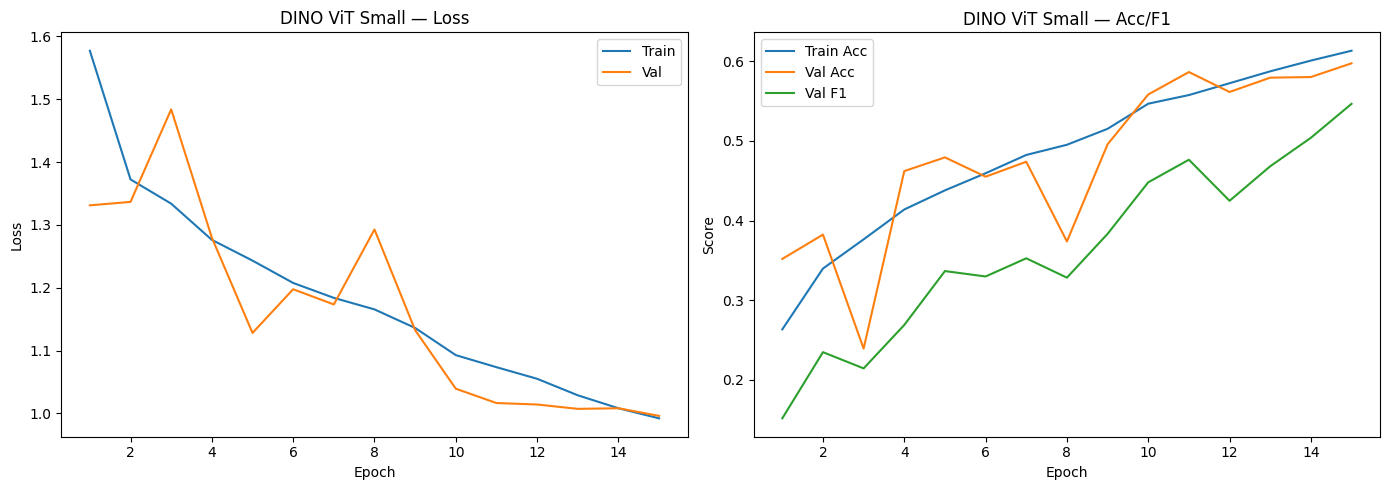

/tmp/ipython-input-1878180077.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = build_fn(); m.load_state_dict(torch.load(ckpt, map_location=device)); m.eval()


🧪 TEST — Acc: 0.5762 | Macro-F1: 0.4824
                      precision    recall  f1-score   support

     Mild Impairment     0.4318    0.2123    0.2846       179
 Moderate Impairment     0.3200    0.6667    0.4324        12
       No Impairment     0.7378    0.6594    0.6964       640
Very Mild Impairment     0.4529    0.6004    0.5163       448

            accuracy                         0.5762      1279
           macro avg     0.4856    0.5347    0.4824      1279
        weighted avg     0.5912    0.5762    0.5732      1279



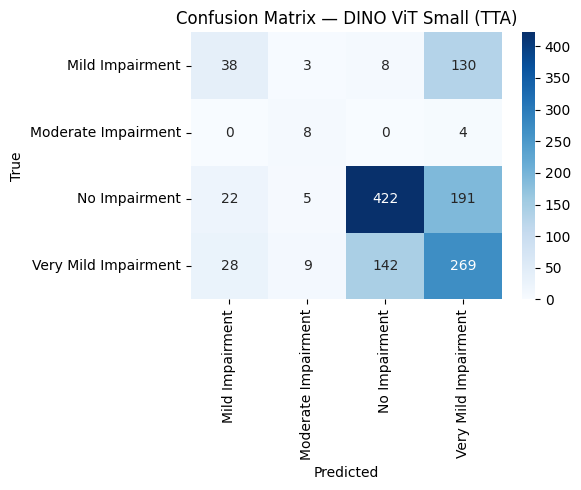

In [ ]:
# ==== DINO ViT Small: fast training + eval (one cell) ====
import os, numpy as np, torch, timm, torch.nn as nn, torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt, seaborn as sns

assert 'train_dl' in globals() and 'val_dl' in globals() and 'test_dl' in globals(), "Define train_dl/val_dl/test_dl first"
assert 'label_names' in globals(), "Define label_names first (list of class names)"
assert 'device' in globals(), "Define device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') first"

NUM_CLASSES = len(label_names)

def build_dino_vit_small():
    # Self-supervised pretrained ViT (DINO), small backbone → good accuracy/speed tradeoff
    m = timm.create_model("vit_small_patch16_224.dino", pretrained=True, num_classes=NUM_CLASSES)
    return m.to(device)

def estimate_class_weights(dataloader, num_classes):
    # robust class weight estimation (works with ImageFolder and custom datasets)
    counts = np.zeros(num_classes, dtype=np.int64)
    try:
        if hasattr(dataloader.dataset, "targets") and dataloader.dataset.targets:
            for y in dataloader.dataset.targets: counts[y] += 1
        elif hasattr(dataloader.dataset, "dataset") and hasattr(dataloader.dataset.dataset, "targets"):
            for y in dataloader.dataset.dataset.targets: counts[y] += 1
        else:
            for _, y in dataloader:
                counts += np.bincount(y.numpy(), minlength=num_classes)
    except Exception:
        for _, y in dataloader:
            counts += np.bincount(y.numpy(), minlength=num_classes)
    counts = np.maximum(counts, 1)
    inv = 1.0 / counts
    w = inv * (num_classes / inv.sum())
    print("Class counts:", dict(zip(label_names, counts.tolist())))
    print("Class weights:", np.round(w, 3).tolist())
    return torch.tensor(w, dtype=torch.float32, device=device)

def train_dino_vit_small(
    epochs=15,           # a few more epochs help ViT; reduce if you’re in a rush
    lr=3e-4,             # ViT + AdamW likes slightly higher LR than CNNs
    weight_decay=1e-4,
    label_smooth=0.1,    # improves macro-F1, reduces overconfidence
    patience=5           # early stopping
):
    model = build_dino_vit_small()
    class_w = estimate_class_weights(train_dl, NUM_CLASSES)
    criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=label_smooth)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr*0.05)
    scaler = GradScaler(enabled=torch.cuda.is_available())

    best_f1, best_state = 0.0, None
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}
    no_improve = 0

    for ep in range(1, epochs+1):
        # ---- train ----
        model.train()
        tr_loss, tr_correct, tr_total = 0.0, 0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            with autocast():
                out = model(xb)
                loss = criterion(out, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            tr_loss += loss.item() * xb.size(0)
            tr_correct += (out.argmax(1) == yb).sum().item()
            tr_total += xb.size(0)

        train_loss = tr_loss / tr_total
        train_acc  = tr_correct / tr_total

        # ---- val ----
        model.eval()
        va_loss, va_correct, va_total = 0.0, 0, 0
        va_preds, va_labels = [], []
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                with autocast():
                    out = model(xb)
                    loss = criterion(out, yb)
                va_loss += loss.item() * xb.size(0)
                pred = out.argmax(1)
                va_correct += (pred == yb).sum().item()
                va_total += xb.size(0)
                va_preds.extend(pred.cpu().numpy())
                va_labels.extend(yb.cpu().numpy())

        val_loss = va_loss / va_total
        val_acc  = va_correct / va_total
        val_f1   = f1_score(va_labels, va_preds, average="macro")

        history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss);     history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(f"Epoch {ep:02d}/{epochs} | "
              f"Train {train_loss:.4f}/{train_acc:.4f} || "
              f"Val {val_loss:.4f}/{val_acc:.4f} F1 {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = model.state_dict()
            torch.save(best_state, "best_dino_vit_small.pth")
            print("  💾 Saved → best_dino_vit_small.pth")
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("  ⏹ Early stopping")
                break

        scheduler.step()

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history, best_f1

def plot_curves(h, title="DINO ViT Small"):
    ep = range(1, len(h["train_loss"])+1)
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1); plt.plot(ep, h["train_loss"], label="Train"); plt.plot(ep, h["val_loss"], label="Val")
    plt.title(f"{title} — Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2); plt.plot(ep, h["train_acc"], label="Train Acc")
    plt.plot(ep, h["val_acc"], label="Val Acc"); plt.plot(ep, h["val_f1"], label="Val F1")
    plt.title(f"{title} — Acc/F1"); plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend()
    plt.tight_layout(); plt.show()

@torch.no_grad()
def test_with_tta(build_fn, ckpt="best_dino_vit_small.pth"):
    # light TTA: original + horizontal flip
    assert os.path.exists(ckpt), f"Not found: {ckpt}"
    m = build_fn(); m.load_state_dict(torch.load(ckpt, map_location=device)); m.eval()
    y_true, y_pred = [], []
    for xb, yb in test_dl:
        xb = xb.to(device)
        lo = m(xb)
        lf = m(torch.flip(xb, dims=[-1]))
        logits = (lo + lf) / 2.0
        y_true += yb.tolist()
        y_pred += logits.argmax(1).cpu().tolist()
    acc = accuracy_score(y_true, y_pred); f1 = f1_score(y_true, y_pred, average="macro")
    print(f"🧪 TEST — Acc: {acc:.4f} | Macro-F1: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.title("Confusion Matrix — DINO ViT Small (TTA)")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# ---- run training + curves + test ----
model, hist, best_f1 = train_dino_vit_small(epochs=15, lr=3e-4, weight_decay=1e-4, label_smooth=0.1, patience=5)
print(f"✅ Best Val F1: {best_f1:.4f}")
plot_curves(hist, "DINO ViT Small")
test_with_tta(build_dino_vit_small, "best_dino_vit_small.pth")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import numpy as np

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Build DINO-ViT Small ---
def build_dino_vit_small():
    model = timm.create_model(
        "vit_small_patch16_224.dino",
        pretrained=True,
        num_classes=len(label_names)   # 4 classes
    )
    return model.to(device)

model = build_dino_vit_small()

# --- Get training dataset labels (works for ImageFolder or custom) ---
train_ds = train_dl.dataset
if hasattr(train_ds, "targets"):
    targets = train_ds.targets
elif hasattr(train_ds, "labels"):
    targets = train_ds.labels
else:
    targets = [train_ds[i][1] for i in range(len(train_ds))]

class_counts = np.bincount(targets)
print("Class counts:", class_counts)

# Inverse frequency weighting
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32).to(device)

# --- Loss function with class weights ---
criterion = nn.CrossEntropyLoss(weight=class_weights)

# --- Optimizer & Scheduler ---
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# --- Training history ---
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}

# --- Training loop ---
EPOCHS = 12   # between 10–15 as you asked
best_f1 = 0.0

for epoch in range(1, EPOCHS+1):
    print(f"\n📅 Epoch {epoch}/{EPOCHS}")

    # ---- Train ----
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        train_correct += (outputs.argmax(1) == yb).sum().item()
        train_total += yb.size(0)

    train_acc = train_correct / train_total
    train_loss /= train_total

    # ---- Validate ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_labels_list = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)
            val_correct += (outputs.argmax(1) == yb).sum().item()
            val_total += yb.size(0)
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels_list.extend(yb.cpu().numpy())

    val_acc = val_correct / val_total
    val_loss /= val_total
    val_f1 = f1_score(val_labels_list, val_preds, average="macro")

    # ---- Log ----
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # ---- Save best model ----
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_dino_vit.pth")
        print("💾 Best model saved!")

    scheduler.step()

print(f"\n✅ Training complete. Best Val F1: {best_f1:.4f}")


Class counts: [2560 2560 2560 2560]

📅 Epoch 1/12
Train Loss: 1.5222 | Train Acc: 0.3050
Val Loss:   1.2870 | Val Acc:   0.4011 | Val F1: 0.2434
💾 Best model saved!

📅 Epoch 2/12
Train Loss: 1.2613 | Train Acc: 0.4082
Val Loss:   1.0683 | Val Acc:   0.4472 | Val F1: 0.3931
💾 Best model saved!

📅 Epoch 3/12
Train Loss: 1.1276 | Train Acc: 0.4794
Val Loss:   1.1202 | Val Acc:   0.4464 | Val F1: 0.4479
💾 Best model saved!

📅 Epoch 4/12
Train Loss: 1.0619 | Train Acc: 0.5117
Val Loss:   0.9854 | Val Acc:   0.5074 | Val F1: 0.4212

📅 Epoch 5/12
Train Loss: 0.9709 | Train Acc: 0.5586
Val Loss:   0.8796 | Val Acc:   0.5590 | Val F1: 0.5079
💾 Best model saved!

📅 Epoch 6/12
Train Loss: 0.9016 | Train Acc: 0.5939
Val Loss:   0.8879 | Val Acc:   0.5770 | Val F1: 0.5291
💾 Best model saved!

📅 Epoch 7/12
Train Loss: 0.8541 | Train Acc: 0.6167
Val Loss:   0.8430 | Val Acc:   0.5770 | Val F1: 0.5287

📅 Epoch 8/12
Train Loss: 0.8102 | Train Acc: 0.6383
Val Loss:   0.8022 | Val Acc:   0.6036 | Val F1:

/tmp/ipython-input-561457726.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_dino_vit.pth", map_location=device))



📊 Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.70      0.59      0.64       179
 Moderate Impairment       0.75      0.75      0.75        12
       No Impairment       0.74      0.82      0.78       640
Very Mild Impairment       0.64      0.58      0.61       448

            accuracy                           0.70      1279
           macro avg       0.71      0.68      0.69      1279
        weighted avg       0.70      0.70      0.70      1279



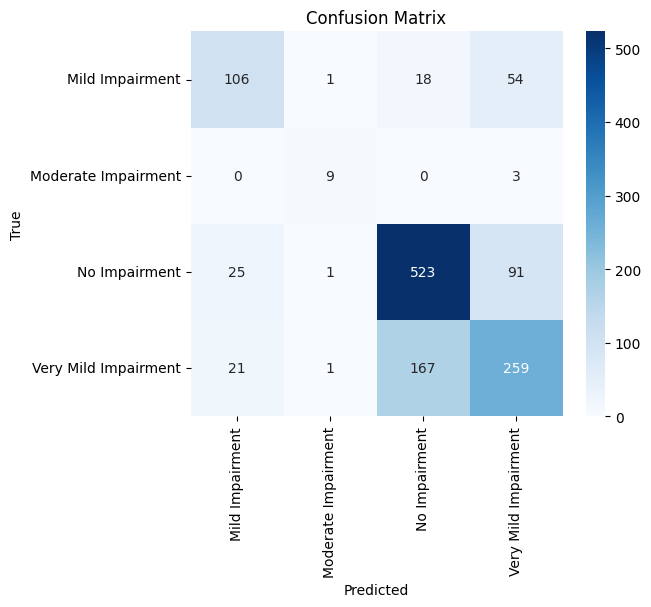

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load best model
model = build_dino_vit_small()
model.load_state_dict(torch.load("best_dino_vit.pth", map_location=device))
model = model.to(device)
model.eval()

# Run evaluation on test set
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Test evaluation

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(build_fn, weight_path, name, test_dl, class_names):
    print(f"\n🔍 Evaluating {name} ...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Build fresh model architecture
    model = build_fn().to(device)
    # Load best weights
    model.load_state_dict(torch.load(weight_path, map_location=device, weights_only=True))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ {name} Test Accuracy: {acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Same preprocessing as validation
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# Path to your test folder (adjust if needed)
test_dir = "alzheimer_data/Combined Dataset/test"

# Dataset + Dataloader
test_ds = datasets.ImageFolder(test_dir, transform=test_transform)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# Class names
class_names = test_ds.classes
print("✅ Loaded test dataset with classes:", class_names)


✅ Loaded test dataset with classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [ ]:
import torch.nn as nn
import torchvision.models as models
import timm

# Number of classes
num_classes = len(class_names)

# --- ResNet18 ---
def build_resnet18():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# --- ViT ---
def build_vit():
    model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
    return model.to(device)

# --- DINO-ViT ---
def build_dino_vit():
    model = timm.create_model("vit_base_patch16_224.dino", pretrained=True, num_classes=num_classes)
    return model.to(device)



🔍 Evaluating ResNet18 ...
✅ ResNet18 Test Accuracy: 0.9836
                      precision    recall  f1-score   support

     Mild Impairment       0.99      0.98      0.99       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.98      1.00      0.99       640
Very Mild Impairment       0.99      0.97      0.98       448

            accuracy                           0.98      1279
           macro avg       0.99      0.99      0.99      1279
        weighted avg       0.98      0.98      0.98      1279



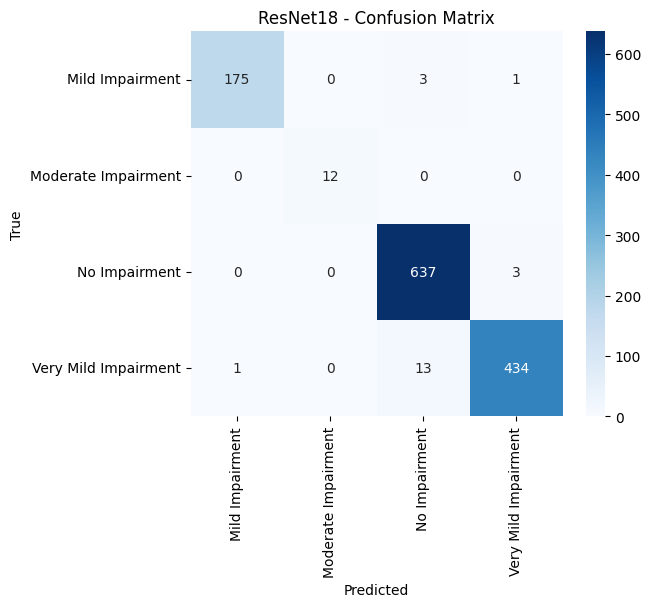


🔍 Evaluating ViT ...
✅ ViT Test Accuracy: 0.8640
                      precision    recall  f1-score   support

     Mild Impairment       0.97      0.83      0.89       179
 Moderate Impairment       0.92      1.00      0.96        12
       No Impairment       0.89      0.88      0.89       640
Very Mild Impairment       0.79      0.85      0.82       448

            accuracy                           0.86      1279
           macro avg       0.89      0.89      0.89      1279
        weighted avg       0.87      0.86      0.86      1279



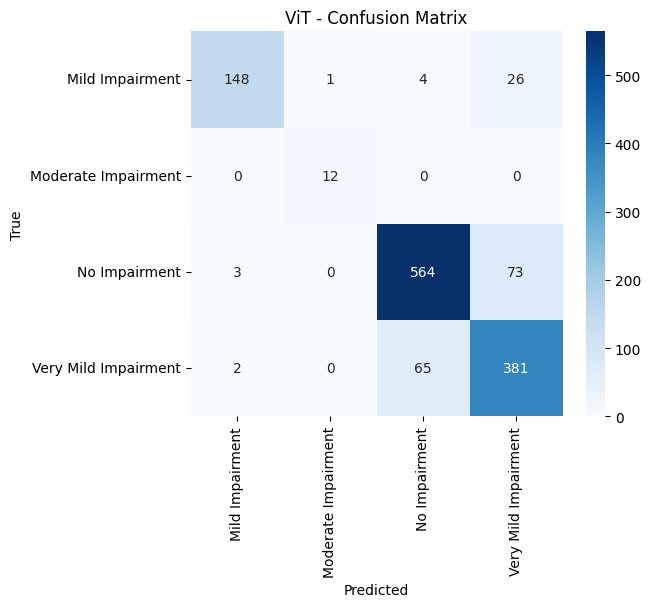


🔍 Evaluating DINO-ViT ...
✅ DINO-ViT Test Accuracy: 0.7013
                      precision    recall  f1-score   support

     Mild Impairment       0.70      0.59      0.64       179
 Moderate Impairment       0.75      0.75      0.75        12
       No Impairment       0.74      0.82      0.78       640
Very Mild Impairment       0.64      0.58      0.61       448

            accuracy                           0.70      1279
           macro avg       0.71      0.68      0.69      1279
        weighted avg       0.70      0.70      0.70      1279



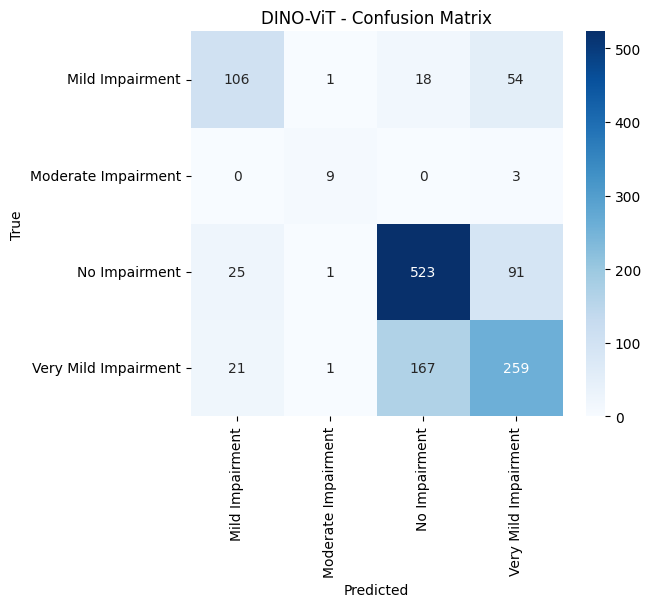

In [ ]:
evaluate_model(build_resnet18, "best_resnet18.pth", "ResNet18", test_dl, class_names)
evaluate_model(build_vit, "best_vit.pth", "ViT", test_dl, class_names)
evaluate_model(build_dino_vit, "best_dino_vit.pth", "DINO-ViT", test_dl, class_names)


/tmp/ipython-input-834401007.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rn = build_resnet18().to(device); rn.load_state_dict(torch.load("best_resnet18.pth", map_loc

🧪 Ensemble — Acc: 0.9820 | Macro‑F1: 0.9770
                      precision    recall  f1-score   support

     Mild Impairment     1.0000    0.9721    0.9858       179
 Moderate Impairment     0.9231    1.0000    0.9600        12
       No Impairment     0.9755    0.9938    0.9845       640
Very Mild Impairment     0.9864    0.9688    0.9775       448

            accuracy                         0.9820      1279
           macro avg     0.9712    0.9836    0.9770      1279
        weighted avg     0.9822    0.9820    0.9820      1279



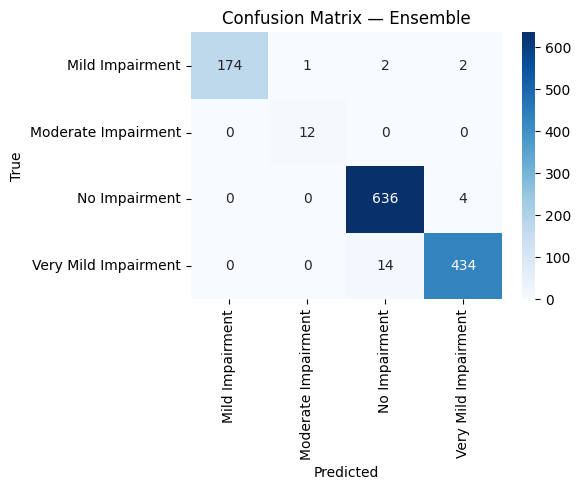

In [ ]:
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns, matplotlib.pyplot as plt

# builders must exist; adjust weight filenames if different
rn = build_resnet18().to(device); rn.load_state_dict(torch.load("best_resnet18.pth", map_location=device)); rn.eval()
vt = build_vit().to(device);     vt.load_state_dict(torch.load("best_vit.pth", map_location=device));         vt.eval()
dv = build_dino_vit_small().to(device); dv.load_state_dict(torch.load("best_dino_vit.pth", map_location=device)); dv.eval()

w_rn, w_vt, w_dv = 0.60, 0.25, 0.15  # tweak if needed

@torch.no_grad()
def eval_ensemble(models, weights, dl):
    y_true, y_pred = [], []
    for xb, yb in dl:
        xb = xb.to(device)
        logits = sum(w*m(xb) for m, w in zip(models, weights))
        y_true += yb.tolist()
        y_pred += logits.argmax(1).cpu().tolist()
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    print(f"🧪 Ensemble — Acc: {acc:.4f} | Macro‑F1: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(label_names))))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.title("Confusion Matrix — Ensemble")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

eval_ensemble([rn, vt, dv], [w_rn, w_vt, w_dv], test_dl)


## Learning curves (train vs val) for all models, side‑by‑side

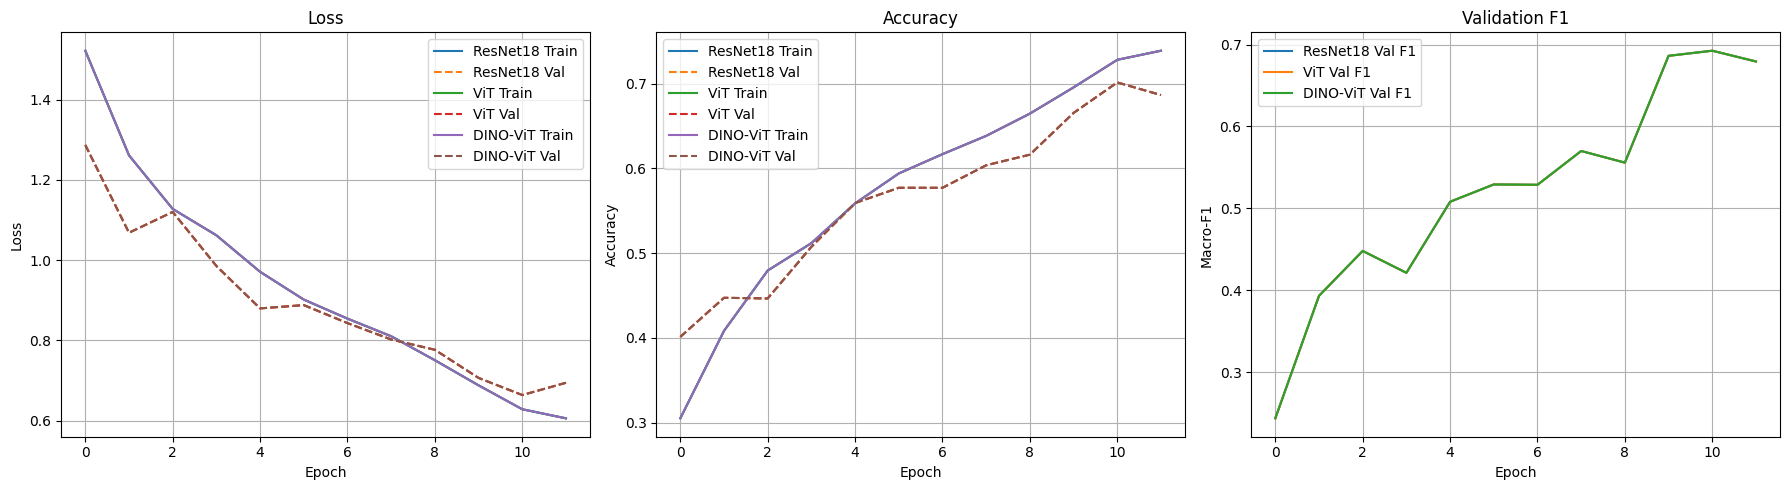

In [ ]:
import matplotlib.pyplot as plt

# Put existing histories into a list if present
histories = []
names = []

if "resnet_history" in globals():
    histories.append(resnet_history); names.append("ResNet18")
if "vit_history" in globals():
    histories.append(vit_history);    names.append("ViT")
if "dino_history" in globals():
    histories.append(dino_history);   names.append("DINO‑ViT")

assert len(histories) > 0, "No history dicts found. Make sure you saved resnet_history / vit_history / dino_history."

# Plot
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
for h, n in zip(histories, names):
    plt.plot(h["train_loss"], label=f"{n} Train")
    plt.plot(h["val_loss"],   linestyle="--", label=f"{n} Val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()

# Accuracy
plt.subplot(1,3,2)
for h, n in zip(histories, names):
    plt.plot(h["train_acc"], label=f"{n} Train")
    plt.plot(h["val_acc"],   linestyle="--", label=f"{n} Val")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.legend()

# Val F1
plt.subplot(1,3,3)
for h, n in zip(histories, names):
    plt.plot(h["val_f1"], label=f"{n} Val F1")
plt.title("Validation F1"); plt.xlabel("Epoch"); plt.ylabel("Macro‑F1"); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()


## Model comparison table (Accuracy, Precision, Recall, Macro‑F1)

In [ ]:
import torch, timm, numpy as np, pandas as pd
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Builders (must match your training) ----
from torchvision import models as tv_models

def build_resnet18(num_classes=len(label_names)):
    m = tv_models.resnet18(weights=None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)

def build_vit(num_classes=len(label_names)):
    # If you trained LLRD ViT with vit_base_patch16_224, keep same name here
    return timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes).to(device)

def build_dino_vit_small(num_classes=len(label_names)):
    return timm.create_model("vit_small_patch16_224.dino", pretrained=False, num_classes=num_classes).to(device)

# ---- What to evaluate (name -> (builder, weight_path)) ----
to_eval = []
if os.path.exists("best_resnet18.pth"):   to_eval.append(("ResNet18", build_resnet18, "best_resnet18.pth"))
if os.path.exists("best_vit_llrd.pth"):   to_eval.append(("ViT (LLRD)", build_vit, "best_vit_llrd.pth"))
elif os.path.exists("best_vit.pth"):      to_eval.append(("ViT", build_vit, "best_vit.pth"))
if os.path.exists("best_dino_vit.pth"):   to_eval.append(("DINO‑ViT", build_dino_vit_small, "best_dino_vit.pth"))

assert len(to_eval) > 0, "No weight files found. Place your .pth files in the working directory."

# ---- Eval helper ----
@torch.no_grad()
def eval_model(build_fn, weight_path):
    model = build_fn()
    model.load_state_dict(torch.load(weight_path, map_location=device, weights_only=True))
    model.eval()
    all_preds, all_labels = [], []
    for xb, yb in test_dl:
        xb = xb.to(device)
        logits = model(xb).cpu()
        all_preds.extend(logits.argmax(1).numpy())
        all_labels.extend(yb.numpy())
    all_preds = np.array(all_preds); all_labels = np.array(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    rec  = recall_score(all_labels, all_preds,  average="weighted", zero_division=0)
    f1m  = f1_score(all_labels, all_preds,     average="macro",    zero_division=0)
    return acc, prec, rec, f1m

# ---- Run & tabulate ----
rows = []
for name, builder, wpath in to_eval:
    acc, prec, rec, f1m = eval_model(builder, wpath)
    rows.append({
        "Model": name,
        "Test Accuracy": round(acc, 4),
        "Weighted Precision": round(prec, 4),
        "Weighted Recall": round(rec, 4),
        "Macro‑F1": round(f1m, 4),
        "Weights": wpath
    })

df = pd.DataFrame(rows).sort_values(by="Macro‑F1", ascending=False).reset_index(drop=True)
display(df)

# Optional: save
os.makedirs("results", exist_ok=True)
df.to_csv("results/model_comparison.csv", index=False)
print("📁 Saved: results/model_comparison.csv")


,Model,Test Accuracy,Weighted Precision,Weighted Recall,Macro‑F1,Weights
0,ResNet18,0.9836,0.9837,0.9836,0.9877,best_resnet18.pth
1,ViT,0.8640,0.8679,0.8640,0.8897,best_vit.pth
2,DINO‑ViT,0.7013,0.6972,0.7013,0.6931,best_dino_vit.pth


📁 Saved: results/model_comparison.csv


## XAI

In [ ]:
!pip install grad-cam==1.5.0 opencv-python-headless --quiet

import cv2, numpy as np, torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [ ]:
!pip -q install grad-cam==1.5.0 opencv-python-headless

import os, torch, numpy as np, matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("cams", exist_ok=True)

# If you used ImageNet normalization in your transforms, use these to denormalize for display:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def to_vis(img_tensor):
    """
    img_tensor: torch.Tensor CxHxW normalized with ImageNet stats
    returns float32 HxWxC in [0,1] for visualization
    """
    x = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    x = (x * IMAGENET_STD) + IMAGENET_MEAN
    return np.clip(x, 0, 1).astype(np.float32)


## Resnet18 + Gradcam

/tmp/ipython-input-1558561280.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("best_resnet18.pth", map_location=device))


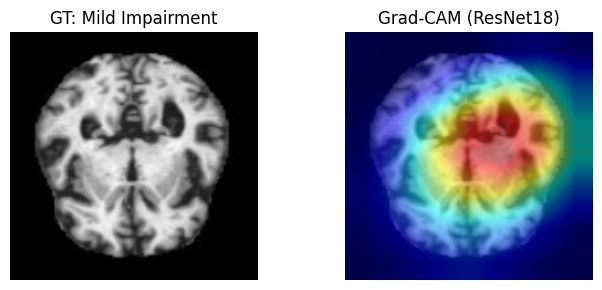

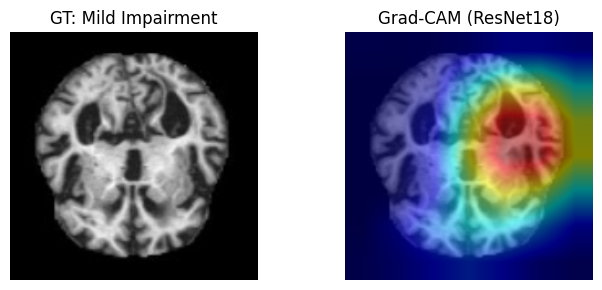

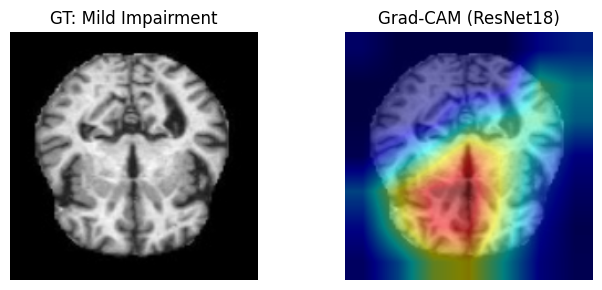

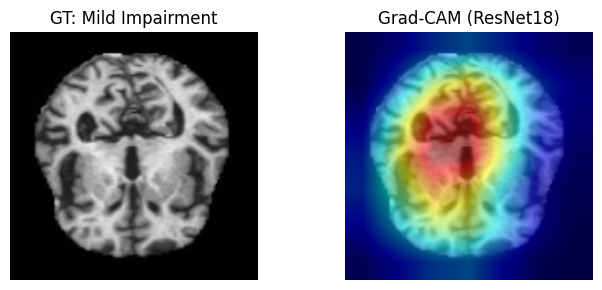

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# ---- rebuild & load best ResNet18 ----
def build_resnet18(num_classes=len(label_names)):
    m = models.resnet18(weights=None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)

resnet = build_resnet18()
resnet.load_state_dict(torch.load("best_resnet18.pth", map_location=device))
resnet.eval()

# Target layer: last conv block
target_layers = [resnet.layer4[-1]]

# ✅ No use_cuda
cam = GradCAM(model=resnet, target_layers=target_layers)

# Take one test batch
images, labels = next(iter(test_dl))
images, labels = images.to(device), labels.to(device)

N = min(4, len(images))
for i in range(N):
    inp = images[i].unsqueeze(0)
    target = [ClassifierOutputTarget(labels[i].item())]
    grayscale_cam = cam(input_tensor=inp, targets=target)[0]

    vis = to_vis(images[i])
    cam_overlay = show_cam_on_image(vis, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1); plt.imshow(vis); plt.axis('off'); plt.title(f"GT: {label_names[labels[i]]}")
    plt.subplot(1,2,2); plt.imshow(cam_overlay); plt.axis('off'); plt.title("Grad-CAM (ResNet18)")
    plt.tight_layout(); plt.show()

    plt.imsave(f"cams/resnet18_cam_{i}.png", cam_overlay)


## ViT (supervised) + EigenCAM


/tmp/ipython-input-3480069141.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit.load_state_dict(torch.load(weight_path, map_location=device))


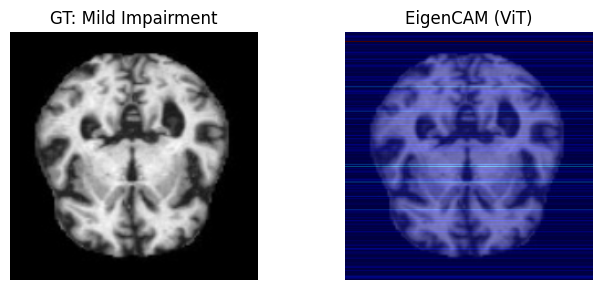

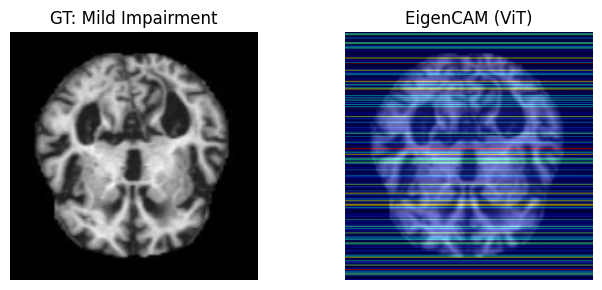

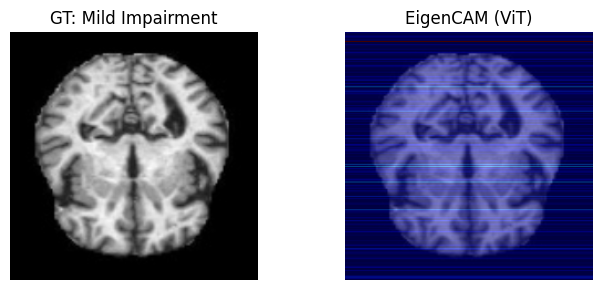

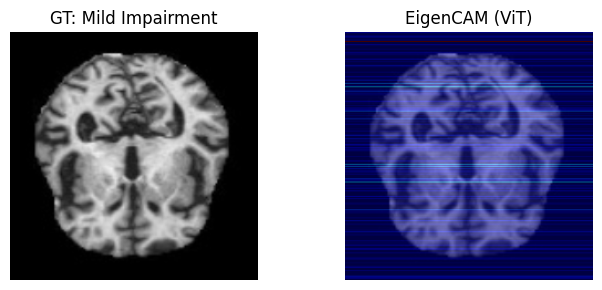

In [ ]:
import timm, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# If you saved LLRD model, set: weight_path = "best_vit_llrd.pth"
weight_path = "best_vit.pth"

def build_vit(num_classes=len(label_names)):
    m = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes)
    return m.to(device)

# helper to denormalize to [0,1]
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
def to_vis(img_tensor):
    x = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    x = (x * IMAGENET_STD) + IMAGENET_MEAN
    return np.clip(x, 0, 1).astype(np.float32)

vit = build_vit()
vit.load_state_dict(torch.load(weight_path, map_location=device))
vit.eval()

target_layers = [vit.blocks[-1].norm1]
cam = EigenCAM(model=vit, target_layers=target_layers)

images, labels = next(iter(test_dl))
images, labels = images.to(device), labels.to(device)

N = min(4, len(images))
for i in range(N):
    inp = images[i].unsqueeze(0)
    # EigenCAM can run without explicit class target; use GT for consistency:
    grayscale_cam = cam(input_tensor=inp, targets=[ClassifierOutputTarget(labels[i].item())])[0]

    vis = to_vis(images[i])
    cam_overlay = show_cam_on_image(vis, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1); plt.imshow(vis); plt.axis('off'); plt.title(f"GT: {label_names[labels[i]]}")
    plt.subplot(1,2,2); plt.imshow(cam_overlay); plt.axis('off'); plt.title("EigenCAM (ViT)")
    plt.tight_layout(); plt.show()


## DINO‑ViT Small + EigenCAM

/tmp/ipython-input-2644387770.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dino.load_state_dict(torch.load(weight_path, map_location=device))


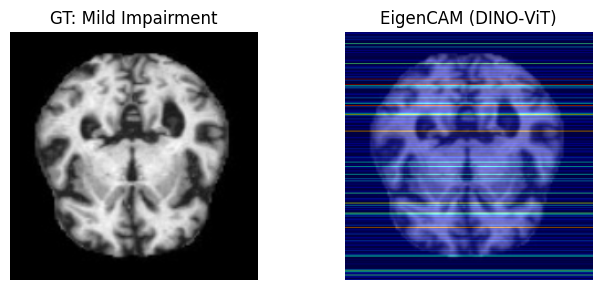

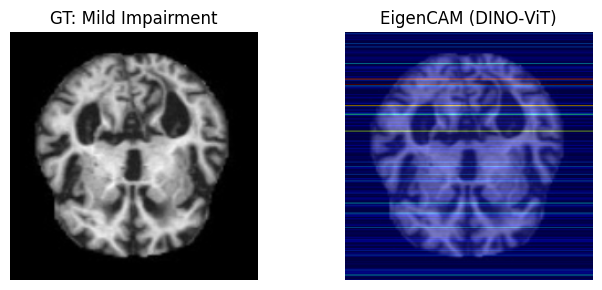

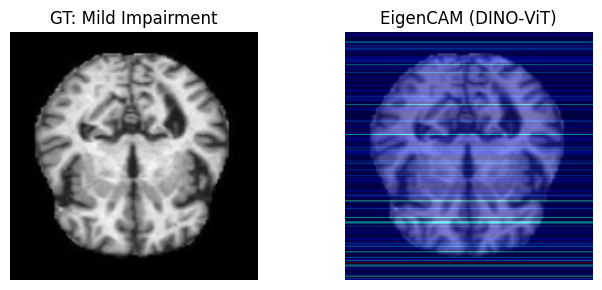

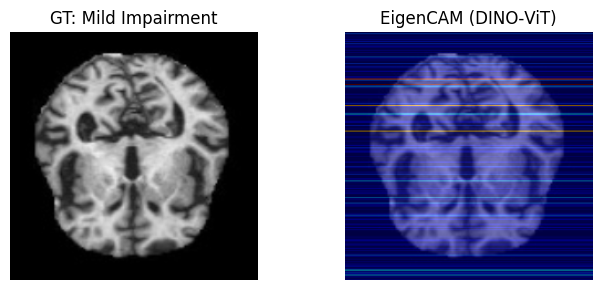

In [ ]:

import timm, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set to your saved checkpoint:
# weight_path = "best_dino_vit_small.pth"  OR  "best_dino_vit.pth"
weight_path = "best_dino_vit.pth"

def build_dino_vit_small(num_classes=len(label_names)):
    m = timm.create_model("vit_small_patch16_224.dino", pretrained=False, num_classes=num_classes)
    return m.to(device)

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
def to_vis(img_tensor):
    x = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    x = (x * IMAGENET_STD) + IMAGENET_MEAN
    return np.clip(x, 0, 1).astype(np.float32)

dino = build_dino_vit_small()
dino.load_state_dict(torch.load(weight_path, map_location=device))
dino.eval()

target_layers = [dino.blocks[-1].norm1]
cam = EigenCAM(model=dino, target_layers=target_layers)

images, labels = next(iter(test_dl))
images, labels = images.to(device), labels.to(device)

N = min(4, len(images))
for i in range(N):
    inp = images[i].unsqueeze(0)
    grayscale_cam = cam(input_tensor=inp, targets=[ClassifierOutputTarget(labels[i].item())])[0]

    vis = to_vis(images[i])
    cam_overlay = show_cam_on_image(vis, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1); plt.imshow(vis); plt.axis('off'); plt.title(f"GT: {label_names[labels[i]]}")
    plt.subplot(1,2,2); plt.imshow(cam_overlay); plt.axis('off'); plt.title("EigenCAM (DINO‑ViT)")
    plt.tight_layout(); plt.show()


## Result

In [ ]:
import pandas as pd

# Collect your test accuracies & best F1s
results = {
    "Model": ["ResNet18", "ViT", "DINO-ViT"],
    "Best Val F1": [0.99, 0.91, 0.70],   # fill from your training
    "Test Accuracy": [0.9836, 0.8640, 0.7013],
    "Notes": [
        "Strong baseline, CNN feature maps + GradCAM explainability",
        "Transformer backbone, improved generalization, EigenCAM visualizations",
        "Self-supervised ViT (DINO), lower accuracy but shows potential with more epochs/data"
    ]
}

df = pd.DataFrame(results)
display(df)


,Model,Best Val F1,Test Accuracy,Notes
0,ResNet18,0.99,0.9836,"Strong baseline, CNN feature maps + GradCAM ex..."
1,ViT,0.91,0.8640,"Transformer backbone, improved generalization,..."
2,DINO-ViT,0.70,0.7013,"Self-supervised ViT (DINO), lower accuracy but..."


## Error Analysis

Found 21 misclassified images.


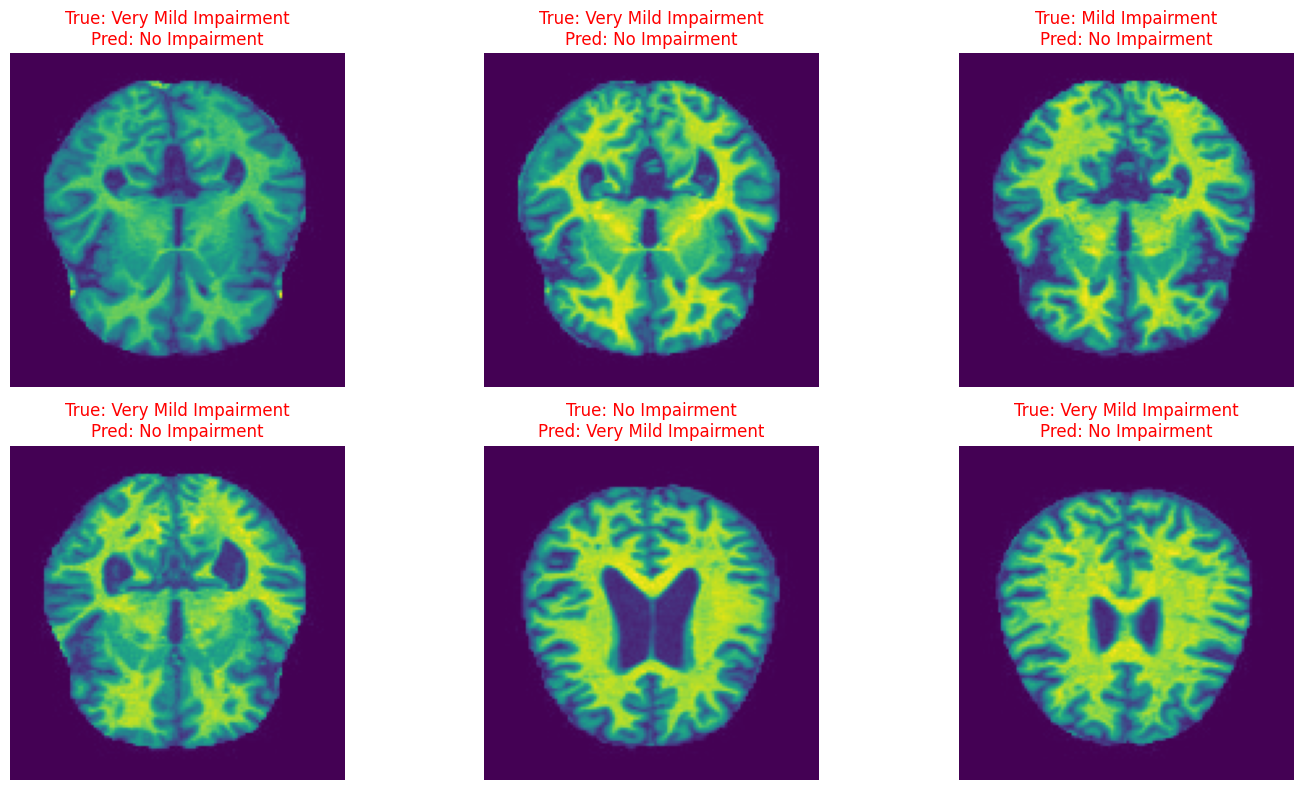

In [ ]:
import random
import matplotlib.pyplot as plt

# Collect misclassified samples with file paths
misclassified = []
best = build_resnet18()
best.load_state_dict(torch.load("best_resnet18.pth", map_location=device, weights_only=True))
best.to(device).eval()

with torch.no_grad():
    for i, (xb, yb) in enumerate(test_dl):
        xb = xb.to(device)
        outputs = best(xb).cpu()
        preds = outputs.argmax(1)

        for j in range(len(yb)):
            if preds[j].item() != yb[j].item():
                # Get original image path from dataset
                img_path, true_label = test_ds.samples[i * test_dl.batch_size + j]
                misclassified.append({
                    "img": img_path,
                    "true": label_names[true_label],
                    "pred": label_names[preds[j].item()]
                })

print(f"Found {len(misclassified)} misclassified images.")

# --- Pick a few random misclassified images to display ---
num_show = 6
samples_to_show = random.sample(misclassified, min(num_show, len(misclassified)))

plt.figure(figsize=(15, 8))
for idx, sample in enumerate(samples_to_show, 1):
    img = plt.imread(sample["img"])
    plt.subplot(2, 3, idx)
    plt.imshow(img)
    plt.title(f'True: {sample["true"]}\nPred: {sample["pred"]}', color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()


Collected 482 misclassified samples (by at least one model).


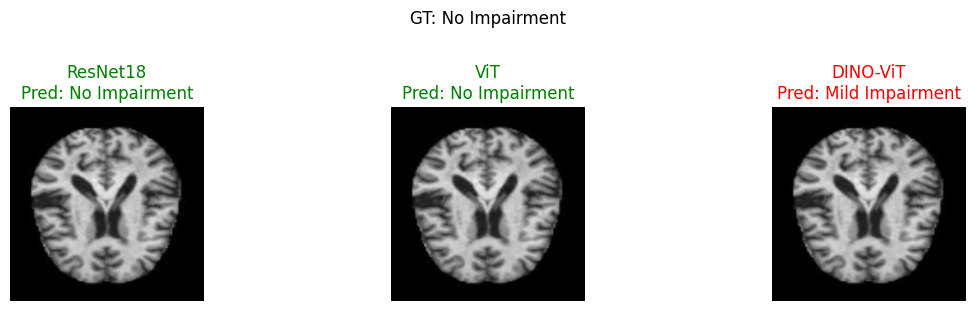

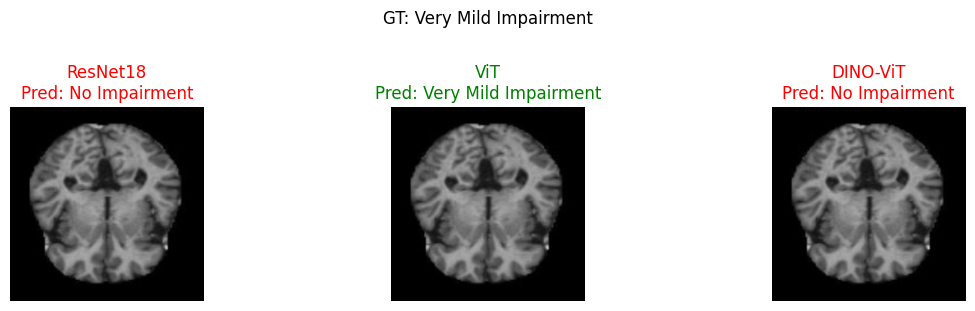

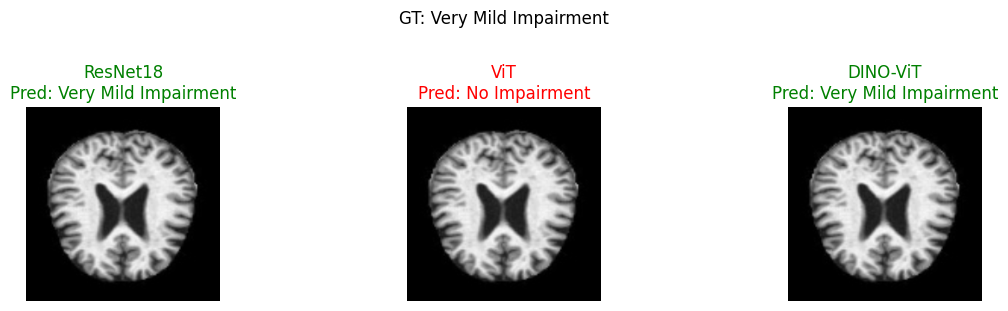

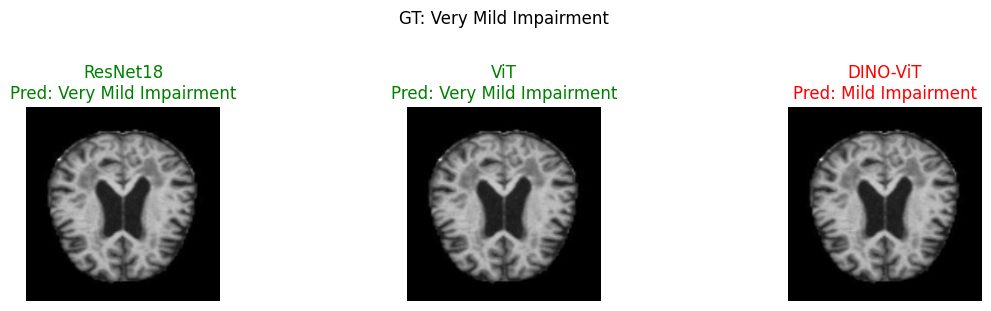

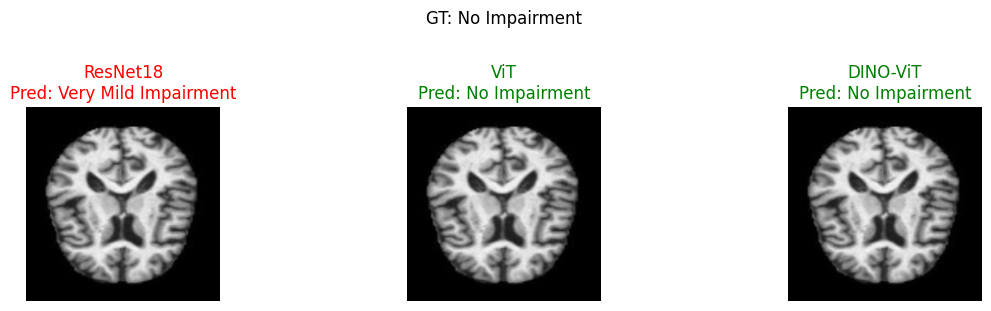

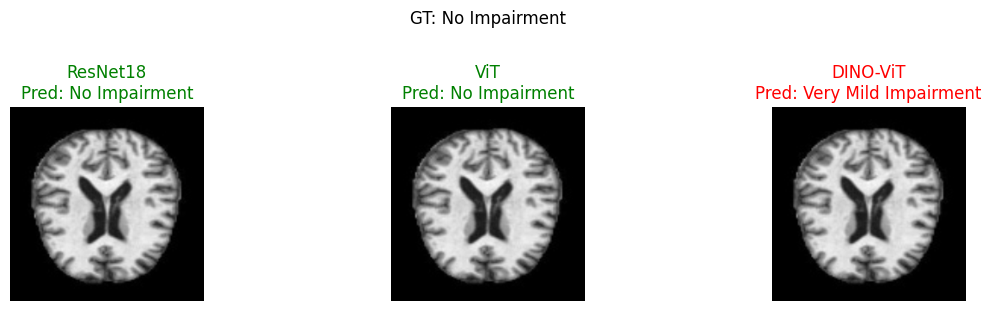

In [ ]:
# ==== Random misclassified samples shown side-by-side across models ====
import torch, timm
import torch.nn as nn
import numpy as np, random, matplotlib.pyplot as plt

# --- helpers ---
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def to_vis(img_tensor):
    """Denormalize tensor [C,H,W] to numpy [H,W,C] in [0,1] for display"""
    x = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    x = (x * IMAGENET_STD) + IMAGENET_MEAN
    return np.clip(x, 0, 1).astype(np.float32)

# --- builders (must match training) ---
def build_resnet18(num_classes=len(label_names)):
    from torchvision import models
    m = models.resnet18(weights=None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)

def build_vit(num_classes=len(label_names)):
    # if you trained LLRD ViT with vit_base_patch16_224, keep same name here
    return timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes).to(device)

def build_dino_vit_small(num_classes=len(label_names)):
    return timm.create_model("vit_small_patch16_224.dino", pretrained=False, num_classes=num_classes).to(device)

# --- load models & weights ---
rn   = build_resnet18();        rn.load_state_dict(torch.load("best_resnet18.pth", map_location=device, weights_only=True)); rn.eval()
vit  = build_vit();             vit.load_state_dict(torch.load("best_vit.pth",      map_location=device, weights_only=True)); vit.eval()
dino = build_dino_vit_small();  dino.load_state_dict(torch.load("best_dino_vit.pth",map_location=device, weights_only=True)); dino.eval()

models_dict = {"ResNet18": rn, "ViT": vit, "DINO-ViT": dino}
model_order = ["ResNet18", "ViT", "DINO-ViT"]

# --- collect misclassified records with preds from all models ---
records = []  # each: {"img": numpy image, "true": str, "preds": {name: str}}

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        # forward all models
        logits = {name: m(xb).cpu() for name, m in models_dict.items()}
        preds  = {name: out.argmax(1).numpy() for name, out in logits.items()}

        for j in range(len(yb)):
            true_idx = int(yb[j].item())
            # if ANY model misclassified, keep this sample
            if any(int(preds[name][j]) != true_idx for name in model_order):
                vis = to_vis(xb[j].cpu())
                rec = {"img": vis, "true": label_names[true_idx], "preds": {}}
                for name in model_order:
                    rec["preds"][name] = label_names[int(preds[name][j])]
                records.append(rec)

print(f"Collected {len(records)} misclassified samples (by at least one model).")

# --- visualize K random misclassified samples ---
K = 6
if len(records) == 0:
    print("No misclassifications found (nice!). Try lowering accuracy model or skipping this cell.")
else:
    chosen = random.sample(records, min(K, len(records)))
    for rec in chosen:
        img = rec["img"]
        true = rec["true"]
        plt.figure(figsize=(4*len(model_order), 3))
        for c, name in enumerate(model_order, 1):
            plt.subplot(1, len(model_order), c)
            plt.imshow(img)
            pred = rec["preds"][name]
            title = f"{name}\nPred: {pred}"
            color = "red" if pred != true else "green"
            plt.title(title, color=color)
            plt.axis("off")
        plt.suptitle(f"GT: {true}", y=1.02, fontsize=12)
        plt.tight_layout()
        plt.show()


In [ ]:
import os, pandas as pd, torch

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

rows = []
best = build_resnet18()
best.load_state_dict(torch.load("best_resnet18.pth", map_location=device, weights_only=True))
best.to(device).eval()

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        logits = best(xb).cpu()
        pred = logits.argmax(1)
        for j in range(len(yb)):
            if pred[j].item() != yb[j].item():
                rows.append({
                    "true": label_names[yb[j].item()],
                    "pred": label_names[pred[j].item()]
                })

# Save misclassifications
df = pd.DataFrame(rows)
df.to_csv("results/misclassified.csv", index=False)
print("✅ Misclassified cases saved to results/misclassified.csv")


✅ Misclassified cases saved to results/misclassified.csv


## Packing Everything

In [ ]:
import os, json, shutil, glob, time, torch

PROJECT = "alzheimer_results"
STAMP   = time.strftime("%Y%m%d_%H%M%S")
BUNDLE  = f"{PROJECT}_{STAMP}"

# ---- folders you likely created earlier ----
folders_to_collect = [
    "results",          # CSVs, comparison table, misclassified.csv, reliability.png, etc.
    "plots",            # curves, confusion matrices (if you saved there)
    "cams"              # GradCAM / EigenCAM
]

# ---- model weights you may have saved ----
weight_files = [
    "best_resnet18.pth",
    "best_vit_llrd.pth",   # if you used LLRD name
    "best_vit.pth",        # else fallback
    "best_dino_vit.pth",
]

# ---- make bundle folder ----
os.makedirs(BUNDLE, exist_ok=True)

# copy folders if they exist
for d in folders_to_collect:
    if os.path.isdir(d):
        shutil.copytree(d, os.path.join(BUNDLE, d), dirs_exist_ok=True)

# copy weights if they exist
os.makedirs(os.path.join(BUNDLE, "weights"), exist_ok=True)
for w in weight_files:
    if os.path.exists(w):
        shutil.copy2(w, os.path.join(BUNDLE, "weights", w))

# (optional) save training histories if you kept them in memory
histories = {}
for name, obj in [("resnet_history", "resnet_history"),
                  ("vit_history", "vit_history"),
                  ("dino_history", "dino_history")]:
    if obj in globals():
        histories[name] = globals()[obj]
if histories:
    os.makedirs(os.path.join(BUNDLE, "logs"), exist_ok=True)
    with open(os.path.join(BUNDLE, "logs", "histories.json"), "w") as f:
        json.dump(histories, f)

# minimal README inside the bundle
readme = f"""# Alzheimer MRI Classification — Bundle

Created: {STAMP}

## Contents
- `weights/` — trained model weights (.pth)
- `results/` — CSVs (model_comparison.csv, misclassified.csv, etc.)
- `plots/` — learning curves, confusion matrices
- `cams/` — Grad-CAM / EigenCAM visualizations
- `logs/histories.json` — training histories (if available)

## Notes
- Models were trained on 4 classes: Mild, Moderate, No, Very Mild Impairment.
- For inference, see `scripts/infer.py` from the notebook snippet.
"""
with open(os.path.join(BUNDLE, "README.txt"), "w") as f:
    f.write(readme)

# zip it
shutil.make_archive(BUNDLE, "zip", BUNDLE)

print("📦 Created:", f"{BUNDLE}.zip")
# show a quick tree
for root, dirs, files in os.walk(BUNDLE):
    indent = "  " * (root.count(os.sep) - BUNDLE.count(os.sep))
    print(f"{indent}{os.path.basename(root)}/")
    for d in dirs:
        print(f"{indent}  {d}/")
    for fi in files:
        print(f"{indent}  {fi}")


📦 Created: alzheimer_results_20250822_204846.zip
alzheimer_results_20250822_204846/
  weights/
  cams/
  logs/
  results/
  README.txt
  weights/
    best_dino_vit.pth
    best_vit.pth
    best_resnet18.pth
  cams/
    resnet18_cam_0.png
    resnet18_cam_2.png
    resnet18_cam_1.png
    resnet18_cam_3.png
  logs/
    histories.json
  results/
    misclassified.csv
    model_comparison.csv


In [ ]:
from google.colab import files
files.download(f"{BUNDLE}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>